In [ ]:
import csv
from xml.etree import ElementTree as ET
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import seaborn as sns
from tabulate import tabulate
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from collections import Counter

# Handling Personal Data




Since I made my project focused on gaining personal insights it made sense to look at my own data first.
Exported my healthkit data from my phone to get my step data.
The appple healthkit data was not just step data and it came in a file that I had to convert into something I could use.
I also downloaded my spotify data.
My Spotify data came as a five part json file which was just for one year however this was converted into csv using an online converter.
For the health kit data I converted to xml using an online converter then to csv. Then to  filter through for just records containing step data.

I also manually went through my journals, picking out the top five adjectives of each entry, how many pages were written per entry and assigned each entry a mood score based off the adjectives used.


# Filtering and Loading Step Data

In [ ]:

#to only get step counts

tree = ET.parse('export.xml')
root = tree.getroot()

daily_steps = {}

for record in root.iter('Record'):
    # check if the record is for step count
    if record.get('type') == 'HKQuantityTypeIdentifierStepCount':
        # to get daily steps
        start_date_str = record.get('startDate')
        end_date_str = record.get('endDate')
        value = int(float(record.get('value')))  # convert value to int


        start_date = datetime.strptime(start_date_str, "%Y-%m-%d %H:%M:%S %z")
        end_date = datetime.strptime(end_date_str, "%Y-%m-%d %H:%M:%S %z")

        #defining a 24hr period
        current_date = start_date.date()
        while current_date <= end_date.date():

            date_str = current_date.strftime("%Y-%m-%d")

            if date_str in daily_steps:
                daily_steps[date_str] += value
            else:
                daily_steps[date_str] = value

            current_date += timedelta(days=1)

output_file_path = '/content/output_daily_steps_final.csv'

with open(output_file_path, 'w', newline='') as csvfile:
    fieldnames = ['Date', 'Total_Steps']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()

    for date, steps in daily_steps.items():
        writer.writerow({'Date': date, 'Total_Steps': steps})

#this is commented out so a new file isnt produced each time
#files.download('/content/output_daily_steps_final.csv')



In [ ]:


#daily_steps.to_csv('output_daily_steps_final.csv', index=False)


#files.download('output_daily_steps_final.csv')


In [ ]:

daily_steps = pd.read_csv('output_daily_steps_final.csv')

daily_steps['Date'] = pd.to_datetime(daily_steps['Date'])

# Display the DataFrame
daily_steps.head()

print(daily_steps.dtypes)

Date           datetime64[ns]
Total_Steps             int64
dtype: object


## Exploring Step Data!!

In [ ]:
daily_steps['Date'].min() #healthkit data goes back to 2017

Timestamp('2017-10-17 00:00:00')

In [ ]:
steps_copy = daily_steps.copy()

steps_copy['Day_of_week'] = steps_copy['Date'].dt.day_name()

days = steps_copy.groupby('Day_of_week')

average_steps = days['Total_Steps'].mean()

print(average_steps.sort_values(ascending=False))

#Thursdays are my most active days
#Sundays are my least active days
#intrigue
#this is for data from last five years

Day_of_week
Thursday     7351.496644
Wednesday    6904.540268
Tuesday      6724.107383
Saturday     6713.077441
Friday       6519.215488
Monday       6028.628378
Sunday       5911.468013
Name: Total_Steps, dtype: float64


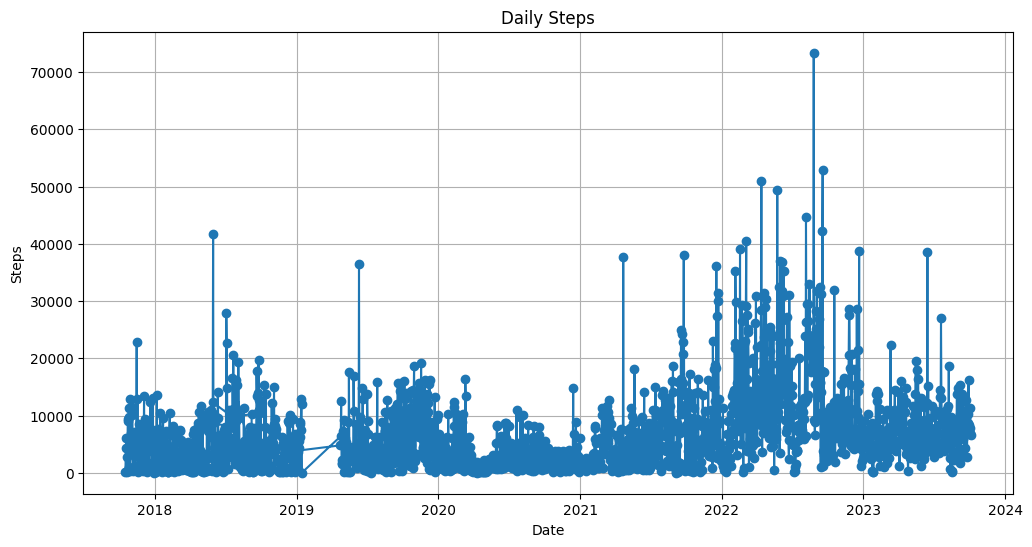

In [ ]:


daily_steps['Date'] = pd.to_datetime(daily_steps['Date'])

plt.figure(figsize=(12, 6))
plt.plot(daily_steps['Date'], daily_steps['Total_Steps'], marker='o', linestyle='-')


plt.title('Daily Steps')
plt.xlabel('Date')
plt.ylabel('Steps')
plt.grid(True)
plt.show()


In [ ]:

start = '2022-10-04'
end = '2023-10-07'


daily_steps_year = daily_steps[(daily_steps['Date'] >= start) & (daily_steps['Date'] <= end)].copy()
daily_steps_year['Date'] = pd.to_datetime(daily_steps_year['Date'], format='%d/%m/%Y')
print(daily_steps_year)


print(daily_steps['Date'].min())

print(daily_steps['Date'].max())

print(daily_steps.isnull().sum()) #no missing values

#now this matches the range for the spotify data!
print(daily_steps_year.dtypes)

           Date  Total_Steps
1714 2022-10-04         9332
1715 2022-10-05         9152
1716 2022-10-06         4910
1717 2022-10-07        11415
1718 2022-10-08         6282
...         ...          ...
2076 2023-10-01         8300
2077 2023-10-02         7021
2078 2023-10-03        11328
2079 2023-10-04         7741
2080 2023-10-05         6584

[367 rows x 2 columns]
2017-10-17 00:00:00
2023-10-05 00:00:00
Date           0
Total_Steps    0
dtype: int64
Date           datetime64[ns]
Total_Steps             int64
dtype: object


In [ ]:

daily_steps_year['Day_of_week'] = daily_steps_year['Date'].dt.day_name()

days = daily_steps_year.groupby('Day_of_week')

average_steps = days['Total_Steps'].mean()

print(average_steps.sort_values(ascending=False))

#Thursdays are my most active days
#Mondays are my least active days
#intrigue


Day_of_week
Thursday     8684.679245
Wednesday    8642.566038
Friday       8413.096154
Saturday     7986.480769
Sunday       7796.461538
Tuesday      7730.716981
Monday       7416.846154
Name: Total_Steps, dtype: float64


In [ ]:

daily_steps_year['Month_Year'] = daily_steps_year['Date'].dt.to_period('M')
monthly_steps_group = daily_steps_year.groupby('Month_Year')

monthly_steps = monthly_steps_group['Total_Steps'].sum()

weeks_per_month = 4.3

weekly_avg_steps = monthly_steps / weeks_per_month


print(weekly_avg_steps)

Month_Year
2022-10    58933.255814
2022-11    85424.883721
2022-12    71168.139535
2023-01    35169.767442
2023-02    42531.627907
2023-03    54832.558140
2023-04    55463.488372
2023-05    58182.790698
2023-06    56712.093023
2023-07    54436.976744
2023-08    47757.441860
2023-09    61007.441860
2023-10     9528.837209
Freq: M, Name: Total_Steps, dtype: float64


Month_Year
2022-10     9050.464286
2022-11    12244.233333
2022-12     9871.709677
2023-01     4878.387097
2023-02     6531.642857
2023-03     7605.806452
2023-04     7949.766667
2023-05     8070.516129
2023-06     8128.733333
2023-07     7550.935484
2023-08     6624.419355
2023-09     8744.400000
2023-10     8194.800000
Freq: M, dtype: float64


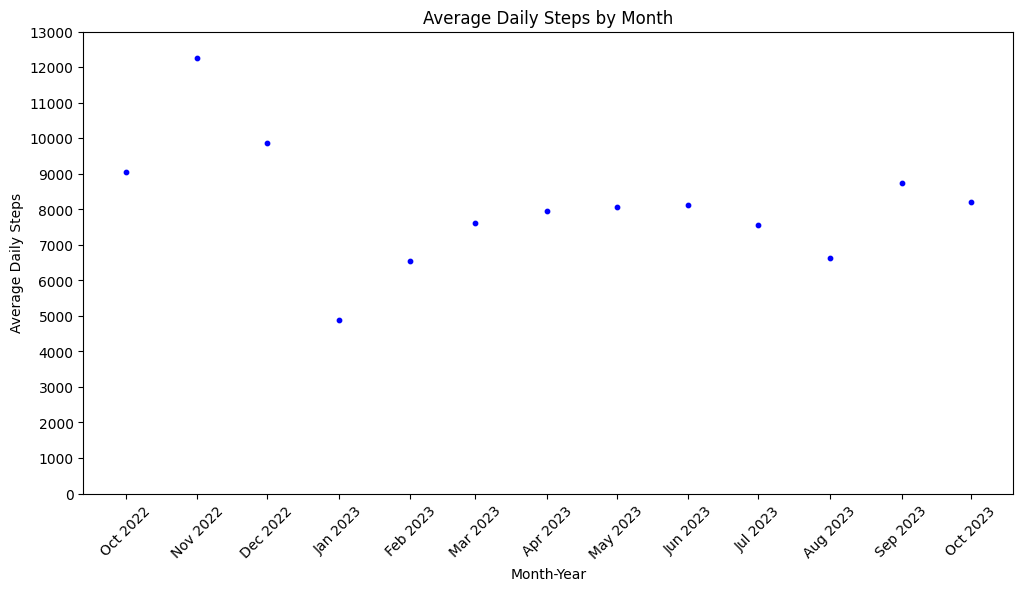

In [ ]:

daily_steps_year['Month_Year'] = daily_steps_year['Date'].dt.to_period('M')

monthly_steps_group = daily_steps_year.groupby('Month_Year')

monthly_steps = monthly_steps_group['Total_Steps'].sum()


days_per_month = monthly_steps_group['Date'].nunique()

daily_avg_steps = monthly_steps / days_per_month


print(daily_avg_steps)


daily_avg_steps.index = pd.to_datetime(daily_avg_steps.index.to_timestamp())

plt.figure(figsize=(12, 6))
plt.scatter(daily_avg_steps.index, daily_avg_steps.values, color='blue', s=10)  # Plot as circles with increased size


plt.xlabel('Month-Year')
plt.ylabel('Average Daily Steps')

plt.title('Average Daily Steps by Month')
plt.xticks(daily_avg_steps.index, [date.strftime('%b %Y') for date in daily_avg_steps.index], rotation=45)
plt.ylim(0)
max_steps = daily_avg_steps.max()
plt.yticks(range(0, int(max_steps) + 1000, 1000))
plt.show()

## Loading and Cleaning Spotify Data

In [ ]:

#the way spotify let me downlooad my data was in five seperate json files rougly five months of data in each.
#converted to csv using online converter.

data1 = pd.read_csv('csvjson.csv')
data2 = pd.read_csv('csvjsonB.csv')
data3 = pd.read_csv('csvjsonC.csv')
data4 = pd.read_csv('csvjsonD.csv')

merged_music_data = pd.concat([data1, data2, data3,data4])

print(merged_music_data.head())

unique_artist_count = merged_music_data['artistName'].nunique()
unique_artist_count # 2637 unique artists would mean an api call for each.

            endTime artistName                    trackName  msPlayed
0  04/10/2022 16:48     S Club            Bring It All Back    141084
1  07/10/2022 06:54     Eminem  Godzilla (feat. Juice WRLD)     85781
2  07/10/2022 06:59     Eminem                Lose Yourself    322226
3  07/10/2022 07:04     Eminem                   Shake That    274440
4  07/10/2022 07:05     Eminem            Guilty Conscience     78472


2637

In [ ]:

merged_music_data['endTime'] = pd.to_datetime(merged_music_data['endTime'])




In [ ]:
#get minutes
merged_music_data['minutesPlayed'] = merged_music_data['msPlayed'] / 60000

# to hours
merged_music_data['hoursPlayed'] = merged_music_data['msPlayed'] / 3600000


# group by date + sum the minutes
daily_listening = merged_music_data.groupby(merged_music_data['endTime'].dt.date)['minutesPlayed'].sum()



daily_listening.head()

daily_listening = daily_listening.reset_index()
daily_listening.columns = ['Date', 'Total_Minutes']

# convert  to datetime
daily_listening['Date'] = pd.to_datetime(daily_listening['Date'])

#daily_listening['Date'].min()

In [ ]:
print(daily_listening.dtypes)

Date             datetime64[ns]
Total_Minutes           float64
dtype: object


##Exploring my Spotify Data!!

In [ ]:

daily_artist_listening = merged_music_data.groupby([merged_music_data['endTime'].dt.date, 'artistName'])['minutesPlayed'].sum().reset_index()


daily_most_listened = daily_artist_listening.loc[daily_artist_listening.groupby('endTime')['minutesPlayed'].idxmax()]

daily_most_listened.columns = ['Date', 'Most_Listened_Artist', 'Total_Minutes_Listened']


daily_most_listened['Date'] = pd.to_datetime(daily_most_listened['Date'])

print(daily_most_listened.head())


          Date Most_Listened_Artist  Total_Minutes_Listened
2   2022-01-11               Bickle               45.286167
33  2022-01-12           Mac Miller               35.622117
50  2022-02-11           Elton John               16.883867
80  2022-02-12             Iggy Pop               29.443267
120 2022-03-11      Michael Jackson              102.770683


In [ ]:
print(daily_listening.head())
print(merged_music_data.head())

        Date  Total_Minutes
0 2022-01-11     216.532667
1 2022-01-12     154.954450
2 2022-02-11      29.274100
3 2022-02-12     320.714317
4 2022-03-11     144.787567
              endTime artistName                    trackName  msPlayed  \
0 2022-04-10 16:48:00     S Club            Bring It All Back    141084   
1 2022-07-10 06:54:00     Eminem  Godzilla (feat. Juice WRLD)     85781   
2 2022-07-10 06:59:00     Eminem                Lose Yourself    322226   
3 2022-07-10 07:04:00     Eminem                   Shake That    274440   
4 2022-07-10 07:05:00     Eminem            Guilty Conscience     78472   

   minutesPlayed  hoursPlayed  
0       2.351400     0.039190  
1       1.429683     0.023828  
2       5.370433     0.089507  
3       4.574000     0.076233  
4       1.307867     0.021798  


In [ ]:
print(merged_music_data.isnull().sum()) #no missing values :)

endTime          0
artistName       0
trackName        0
msPlayed         0
minutesPlayed    0
hoursPlayed      0
dtype: int64


In [ ]:
#hours listened to is easier to picture for now
song_listening = merged_music_data.groupby(['trackName', 'artistName'])['hoursPlayed'].sum()

# my top 40 :)
top_songs = song_listening.sort_values(ascending=False).head(40)

print(top_songs)


trackName                                    artistName                        
invisible string                             Taylor Swift                          17.055587
Get Used To It                               Justin Bieber                         12.075787
The Loneliest Time (feat. Rufus Wainwright)  Carly Rae Jepsen                      10.591547
Stronger                                     Kanye West                            10.321118
All I Have (feat. LL Cool J)                 Jennifer Lopez                         9.924252
Barbie Dreams                                Nicki Minaj                            9.665571
Where I'm From                               Digable Planets                        9.335602
Delicate                                     Taylor Swift                           8.705834
Love On The Brain                            Rihanna                                8.484142
Dreams - 2004 Remaster                       Fleetwood Mac                         

<Figure size 1000x600 with 0 Axes>

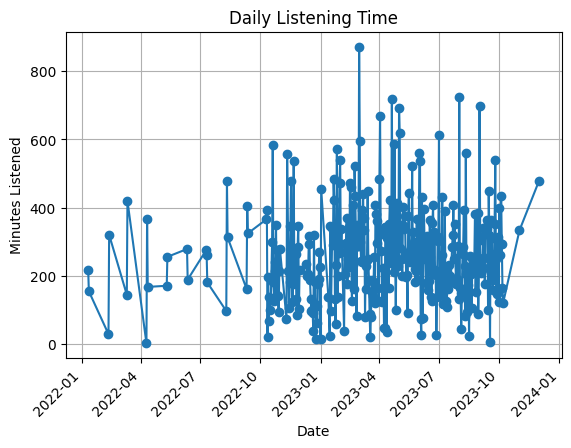

In [ ]:

plt.figure(figsize=(10, 6))

daily_listening.plot(x='Date', marker='o', linestyle='-', grid=True, legend = False)

plt.title('Daily Listening Time')
plt.xlabel('Date')
plt.ylabel('Minutes Listened')

plt.xticks(rotation=45)
plt.grid(True)
plt.show()



In [ ]:
print(daily_listening['Date'].min()) #spotify data only goes back to October 2022
print(daily_listening['Date'].max()) # ends october 2023

2022-01-11 00:00:00
2023-12-01 00:00:00


The Spotify data limits the project scope to a year but there is significant amounts of data here.


## Loading and Cleaning Work Schedules Data

A combination of my work schedules, timesheets and university timetables in one excel file !! These were created manually so not much to do except check the file for any obvious errors and added a useful collumn to calculate duration of shifts.

In [ ]:
work_sched = 'Work_Schedule_Timestamps.csv'

work_sched = pd.read_csv(work_sched)

#print(work_sched.head())

print(work_sched.dtypes)
work_sched['Date'] = pd.to_datetime(work_sched['Date'], format='%d/%m/%Y %H:%M') #i dont know why my excel file was messed but the format needs this otherwise pandas mixes up the days and months :(
work_sched['Start'] = pd.to_datetime(work_sched['Start'], format='%d/%m/%Y %H:%M')
work_sched['End'] = pd.to_datetime(work_sched['End'], format='%d/%m/%Y %H:%M')
print(work_sched.dtypes)

#  each shift
work_sched['Shift Duration'] = (work_sched['End'] - work_sched['Start']).dt.total_seconds() / 3600  # Convert seconds to hours



#issue with my data identified for one the weeks its displaying -210 hours which is wrong

#negative_shifts = work_sched[work_sched['Shift Duration'] < 0]

#print(negative_shifts)

# Job    Job Type       Date               Start  \
#442  Ambassador  Ambassador 2023-05-22 2023-05-22 09:00:00

                   # End  Shift Duration
#442 2023-05-13 15:00:00          -210.0

#fixed manually in excel



print(work_sched.head())

print(work_sched['Date'].min())

print(work_sched['Date'].max())

#' column to represent weeks starting on monday (0 for monday 6 for Sunday)
work_sched['Week'] = work_sched['Date'] - pd.to_timedelta((work_sched['Date'].dt.dayofweek) % 7, unit='D')


work_sched['Month'] = work_sched['Date'].dt.strftime('%Y-%m')

# monthly hours

monthly_hours = work_sched.groupby(['Month'])['Shift Duration'].sum().reset_index()

#weekly hors

weekly_hours = work_sched.groupby(['Week'])['Shift Duration'].sum().reset_index()


weekly_hours.rename(columns={'Shift Duration': 'Weekly Total'}, inplace=True)

monthly_hours.rename(columns={'Shift Duration': 'Monthly Total'}, inplace=True)




print(weekly_hours)
#print(monthly_hours)

print(work_sched.head())

Job         object
Job Type    object
Date        object
Start       object
End         object
dtype: object
Job                 object
Job Type            object
Date        datetime64[ns]
Start       datetime64[ns]
End         datetime64[ns]
dtype: object
                Job                Job Type       Date               Start  \
0  University Class      Big Data Analytics 2022-09-19 2022-09-19 11:00:00   
1  University Class  Mobile App Development 2022-09-20 2022-09-20 12:00:00   
2  University Class            Team Project 2022-09-20 2022-09-20 14:00:00   
3  University Class  Concurrent Programming 2022-09-20 2022-09-20 15:00:00   
4  University Class  Concurrent Programming 2022-09-22 2022-09-22 11:00:00   

                  End  Shift Duration  
0 2022-09-19 12:00:00             1.0  
1 2022-09-20 13:00:00             1.0  
2 2022-09-20 15:00:00             1.0  
3 2022-09-20 16:00:00             1.0  
4 2022-09-22 13:00:00             2.0  
2022-09-19 00:00:00
2023-11-22 00

# Exploring Work Data!

In [ ]:

sorted_monthly_hours = monthly_hours.sort_values('Monthly Total', ascending=False)

highest_work_month = sorted_monthly_hours.iloc[0]


lowest_work_month = sorted_monthly_hours.iloc[-1]

print( highest_work_month) #July with 228 work hours
print(lowest_work_month) #May with 18 work hours


Month            2023-07
Monthly Total      228.0
Name: 10, dtype: object
Month            2023-05
Monthly Total       18.0
Name: 8, dtype: object


In [ ]:
#two pointers to calculate longest streak

work_sched.sort_values(by='Date', inplace=True)
work_sched_unique = work_sched.drop_duplicates(subset=['Date']).copy()


longest_streak = 0
current_streak = 0
prev_date = None

for current_date in work_sched_unique['Date']:

    if prev_date is not None and (current_date - prev_date).days == 1:

        current_streak += 1

    else:

        longest_streak = max(longest_streak, current_streak) #update streak

        current_streak = 1  # start new streak

    prev_date = current_date

max_streak = max(longest_streak, current_streak)  #compare

print(max_streak)

#this is fifty-five days

55


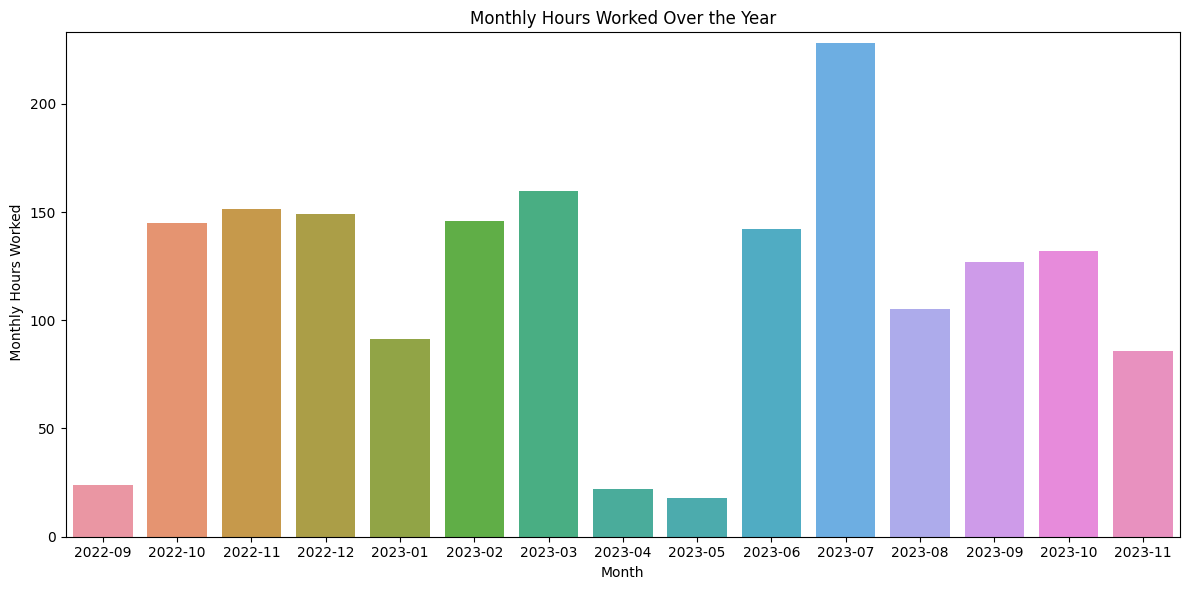

In [ ]:
plt.figure(figsize=(12, 6))

sns.barplot(x='Month', y='Monthly Total', data=monthly_hours, errorbar=None)
plt.xlabel('Month')
plt.ylabel(' Monthly Hours Worked')

plt.title('Monthly Hours Worked Over the Year')

plt.tight_layout()
plt.ylim(0, monthly_hours['Monthly Total'].max() + 5)



plt.show()


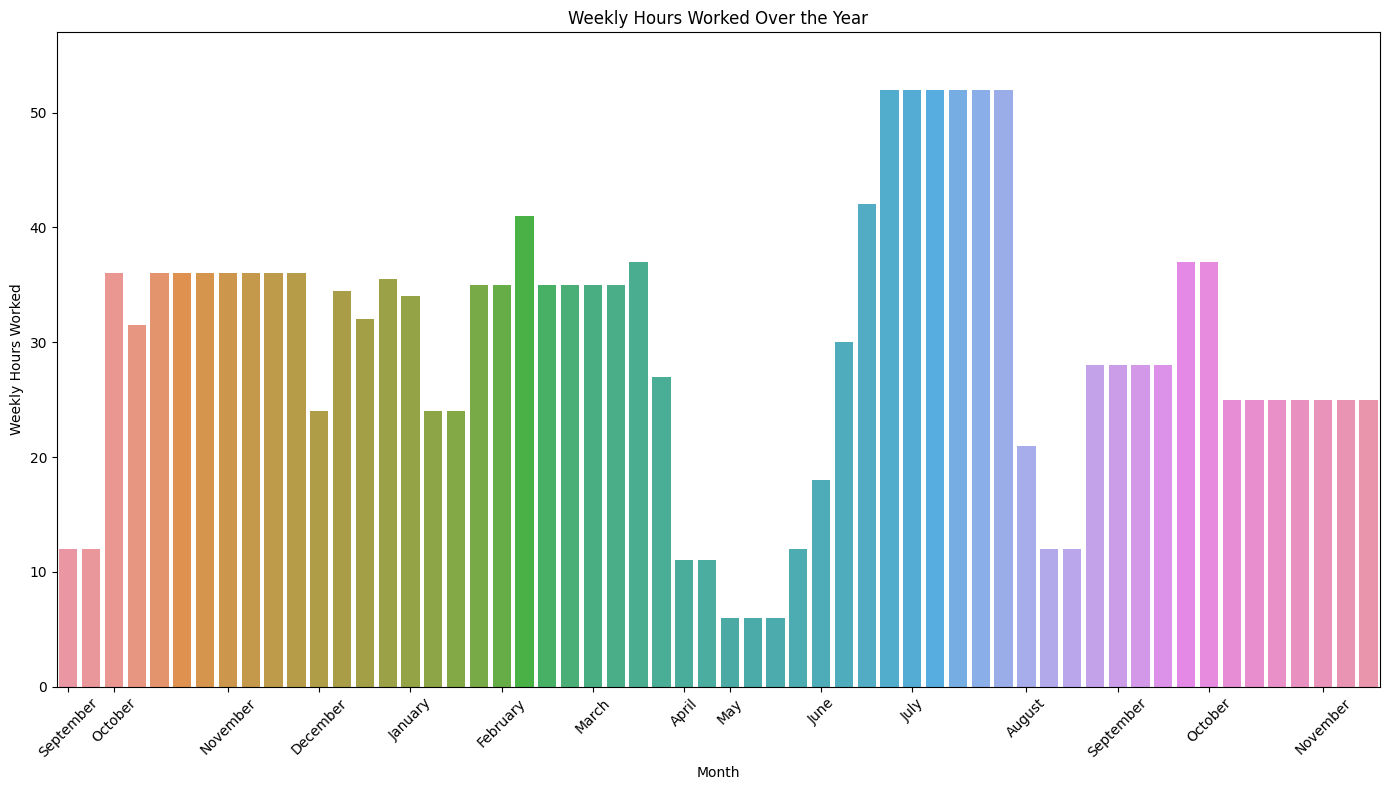

29.767241379310345


In [ ]:

weekly_hours['Month_Year'] = weekly_hours['Week'].dt.strftime('%B %Y')

#finding first index for each month-year bc some months reapeat
first_index_per_month = weekly_hours.groupby('Month_Year').head(1).index


month_labels = [date.strftime('%B') for date in weekly_hours.loc[first_index_per_month, 'Week']]


plt.figure(figsize=(14, 8))
sns.barplot(x='Week', y='Weekly Total', data=weekly_hours, errorbar=None)

plt.xticks(ticks=first_index_per_month, labels=month_labels, rotation=45)

plt.xlabel('Month')
plt.ylabel('Weekly Hours Worked')
plt.title('Weekly Hours Worked Over the Year')

plt.tight_layout()
plt.ylim(0, weekly_hours['Weekly Total'].max() + 5)


plt.show()


average_weekly_hours = weekly_hours['Weekly Total'].mean()

print(average_weekly_hours)


In [ ]:
moods = 'mood_data.csv'
mood_data  = pd.read_csv(moods)

mood_data['Date'] = pd.to_datetime(mood_data['Date'], format='%d/%m/%Y')


print(mood_data.head())

print(mood_data.dtypes)

print(mood_data['Date'].min()) #4th October 22

print(mood_data['Date'].max()) #9th October 23

print(len(mood_data))

print(mood_data.describe())

        Date                              Words  Mood Score  Number of Pages
0 2022-10-10      sad,okay,terrified,alone,fine           1                3
1 2022-10-12     calm,excited,tired,rested,cool           4                5
2 2022-10-19  upset,motivated,loved,kind,upbeat           4                2
3 2022-10-20  sleepy,good,creative,dreamy,happy           5                4
4 2022-10-21      amazing,scared,fun,good,tired           3                1
Date               datetime64[ns]
Words                      object
Mood Score                  int64
Number of Pages             int64
dtype: object
2022-10-04 00:00:00
2023-10-09 00:00:00
100
       Mood Score  Number of Pages
count  100.000000       100.000000
mean     3.860000         2.800000
std      1.392766         2.150875
min      1.000000         1.000000
25%      3.000000         1.000000
50%      5.000000         2.000000
75%      5.000000         4.000000
max      5.000000        10.000000


# Loading Journal Data!!

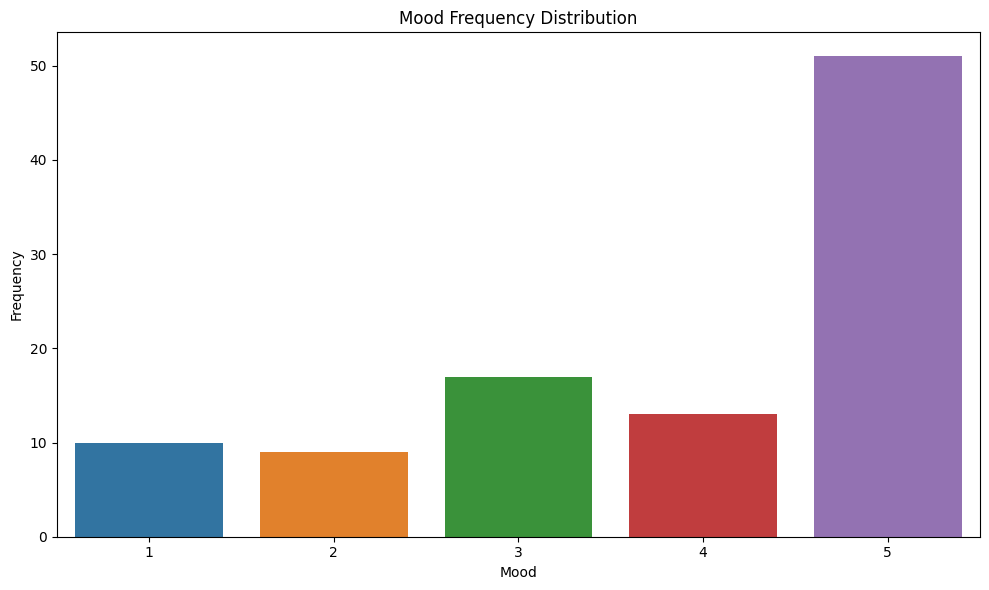

In [ ]:
mood_counts = mood_data['Mood Score'].value_counts()



plt.figure(figsize=(10, 6))

sns.barplot(x=mood_counts.index, y=mood_counts.values)

plt.xlabel('Mood')
plt.ylabel('Frequency')

plt.title('Mood Frequency Distribution')

plt.tight_layout()
plt.show()

#I have more good days than bad!!



average_weekly_hours = weekly_hours['Weekly Total'].mean() #average mood 4 rounded up


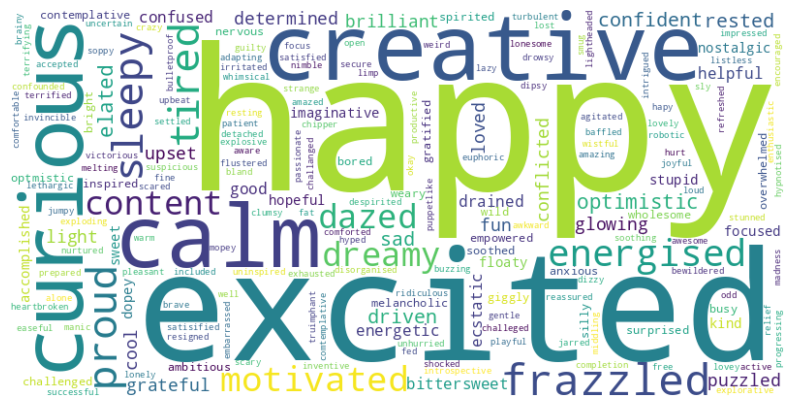

In [ ]:
#MAKIGN A WORD CLOUD!!!!!!!!
words_combined = ' '.join(mood_data['Words'])


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.title('Most Used Adjectives From My Journal')
#plt.savefig('writing_output', dpi=500)
plt.show()


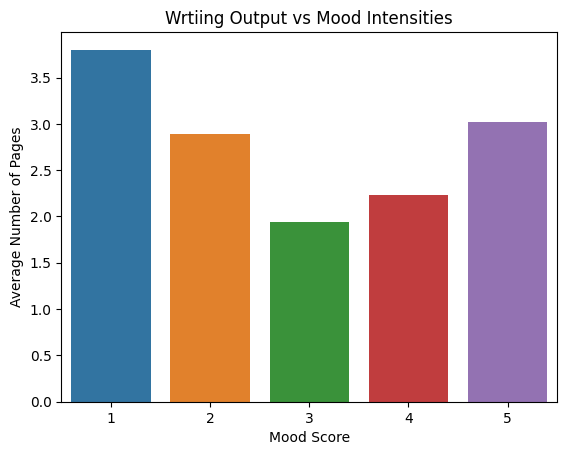

In [ ]:

average_pages= mood_data.groupby('Mood Score')['Number of Pages'].mean().reset_index()

sns.barplot(x='Mood Score', y='Number of Pages', data=average_pages)

plt.xlabel('Mood Score')
plt.ylabel('Average Number of Pages')
plt.title('Wrtiing Output vs Mood Intensities')
plt.savefig('writing_output', dpi=500)
plt.show()

# I write more when I feel intense emotions and less when I feel nuetral

In [ ]:
words = mood_data['Words'].str.split(',').explode()

word_counts = words.value_counts()


top_7_words_all_time = word_counts.head(7)

print(top_7_words_all_time)

#my top seven words of all time for the rainbow in my infographic :)

happy       29
creative    16
excited     16
curious     14
calm        14
frazzled    10
sleepy       9
Name: Words, dtype: int64


In [ ]:

def top_10(data, mood_score):

    filtered_data = data[data['Mood Score'] == mood_score]


    all = ' '.join(filtered_data['Words']).replace(',', ' ').split()


    word_counts = Counter(all)
    return word_counts.most_common(10)

top_10_words_1 = top_10(mood_data, 1)
top_10_words_5 = top_10(mood_data, 5)
top_10_words_3 = top_10(mood_data, 3)
print(top_10_words_1)#lowest
print(top_10_words_5)#happiest
print( top_10_words_3) #nuetral

#getting top ten words for happiest,lowest and nuetral

[('determined', 2), ('drained', 2), ('tired', 2), ('sleepy', 2), ('dazed', 2), ('stupid', 2), ('sad', 1), ('okay', 1), ('terrified', 1), ('alone', 1)]
[('happy', 23), ('creative', 11), ('calm', 10), ('excited', 9), ('curious', 8), ('content', 7), ('proud', 7), ('energised', 6), ('elated', 6), ('confident', 6)]
[('confused', 4), ('curious', 4), ('happy', 4), ('frazzled', 3), ('fun', 2), ('tired', 2), ('sad', 2), ('dazed', 2), ('sleepy', 2), ('weary', 2)]


In [ ]:

mood_data['Date'] = pd.to_datetime(mood_data['Date'])

# align mood_data to the start of each week
mood_data['Week'] = mood_data['Date'] - pd.to_timedelta(mood_data['Date'].dt.dayofweek, unit='d')

weekly_mood = mood_data.groupby('Week')['Mood Score'].mean().reset_index()

# merge weekly hours with weekly mood
weekly_hours['Week'] = pd.to_datetime(weekly_hours['Week'])
work_moods = pd.merge(weekly_hours[:-6], weekly_mood, on='Week', how='left')

print(work_moods.isna().sum()) # 8 missing values

#because there are some weeks I worked but didn't journal gotta fill in missing values

mean = work_moods['Mood Score'].mean()

# replace missing values in the Mood Score column with the mean
work_moods['Mood Score'].fillna(mean, inplace=True)




Week            0
Weekly Total    0
Month_Year      0
Mood Score      7
dtype: int64


## Exploring Factors that Impact My Mood!!!

In [ ]:

correlation = work_moods['Weekly Total'].corr(work_moods['Mood Score'])
print("Correlation coefficient:", correlation) #outputs -0.25
#conclusion as my work hours increase my mood score decreases but only very slightly
#seen better in the following graph

Correlation coefficient: -0.2522511489112617


<ipython-input-129-081ba464fdd0>:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Average Mood Score')


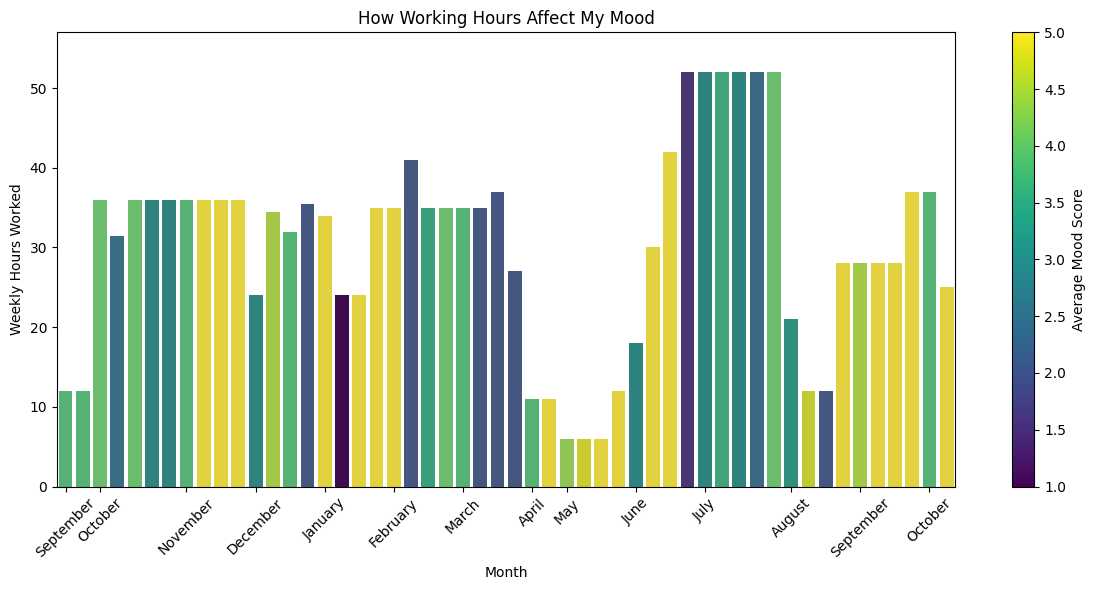

In [ ]:

#colourmap
norm = mcolors.Normalize(vmin=1, vmax=5)
colors = plt.cm.viridis(norm(work_moods['Mood Score']))

#for month labels
month_index = work_moods.groupby('Month_Year').head(1).index
month_labels = [date.strftime('%B') for date in work_moods.loc[month_index, 'Week']]



plt.figure(figsize=(12, 6))
sns.barplot(x='Week', y='Weekly Total', data=work_moods, palette=colors, errorbar=None)

plt.xticks(ticks=month_index, labels=month_labels, rotation=45)

plt.xlabel('Month')
plt.ylabel('Weekly Hours Worked')
plt.title('How Working Hours Affect My Mood')

plt.tight_layout()
plt.ylim(0, work_moods['Weekly Total'].max() + 5)


sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
plt.colorbar(sm, label='Average Mood Score')
plt.savefig('work_moods', dpi=500)
plt.show()


#although hours worked does have an affect on mood it seems its not necessarily guaranteed
#there are alot of happy weeks where i still work lots

<ipython-input-130-144ff7f51e7f>:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Mood Score')


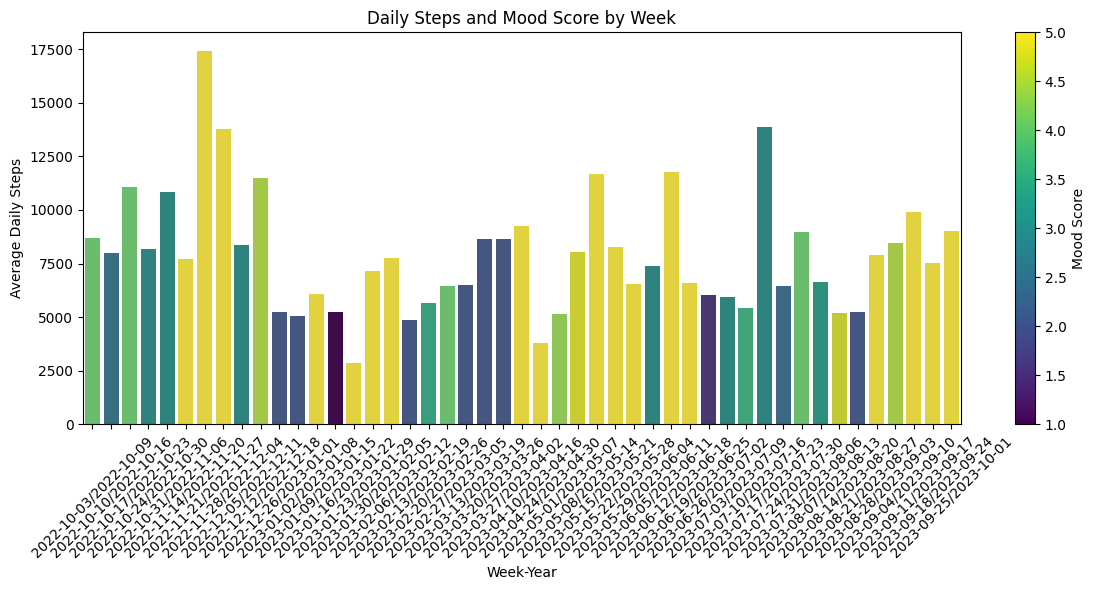

In [ ]:
#monthly steps vs mood


daily_steps_year['Week_Year'] = daily_steps_year['Date'].dt.to_period('W')
mood_data['Week_Year'] = mood_data['Date'].dt.to_period('W')

monthly_steps = daily_steps_year.groupby('Week_Year')['Total_Steps'].mean().reset_index()

monthly_mood = mood_data.groupby('Week_Year')['Mood Score'].mean().reset_index()

merged_data = pd.merge(monthly_steps, monthly_mood, on='Week_Year')

norm = mcolors.Normalize(vmin=merged_data['Mood Score'].min(), vmax=merged_data['Mood Score'].max())
colors = plt.cm.viridis(norm(merged_data['Mood Score']))


plt.figure(figsize=(12, 6))
sns.barplot(x='Week_Year', y='Total_Steps', data=merged_data, palette=colors)

plt.xticks(rotation=45)
plt.xlabel('Week-Year')
plt.ylabel('Average Daily Steps')
plt.title('Daily Steps and Mood Score by Week')

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
plt.colorbar(sm, label='Mood Score')

plt.tight_layout()
plt.show()
#out of my top five four of my highest step weeks are my happiest

In [ ]:
mood_data['Month_Year'] = mood_data['Date'].dt.to_period('M')

def top_5_words_per_month(data, month_year):

    filtered_data = data[data['Month_Year'] == month_year]

    all_words = ' '.join(filtered_data['Words']).replace(',', ' ').split()

    word_counts = Counter(all_words)

    return word_counts.most_common(5)

top_words_by_month = {}
for month_year in mood_data['Month_Year'].unique():

    top_words_by_month[month_year] = top_5_words_per_month(mood_data, month_year)


for month_year, top_words in top_words_by_month.items():
    print(f"top 5 for {month_year}: {top_words}")



top 5 for 2022-10: [('tired', 3), ('sad', 2), ('sleepy', 2), ('good', 2), ('dreamy', 2)]
top 5 for 2022-11: [('happy', 2), ('creative', 2), ('excited', 2), ('wild', 1), ('madness', 1)]
top 5 for 2022-12: [('proud', 3), ('tired', 2), ('overwhelmed', 2), ('excited', 2), ('sleepy', 1)]
top 5 for 2023-01: [('despirited', 1), ('jarred', 1), ('motivated', 1), ('wistful', 1), ('bored', 1)]
top 5 for 2023-02: [('excited', 2), ('proud', 2), ('gratified', 2), ('grateful', 2), ('optimistic', 1)]
top 5 for 2023-03: [('tired', 2), ('bittersweet', 1), ('lonesome', 1), ('fun', 1), ('melancholic', 1)]
top 5 for 2023-04: [('content', 2), ('sad', 1), ('relief', 1), ('bittersweet', 1), ('conflicted', 1)]
top 5 for 2023-05: [('happy', 7), ('curious', 5), ('calm', 5), ('elated', 4), ('rested', 4)]
top 5 for 2023-06: [('puzzled', 3), ('motivated', 2), ('happy', 2), ('guilty', 1), ('sad', 1)]
top 5 for 2023-07: [('frazzled', 5), ('creative', 5), ('sleepy', 4), ('determined', 3), ('excited', 3)]
top 5 for 202

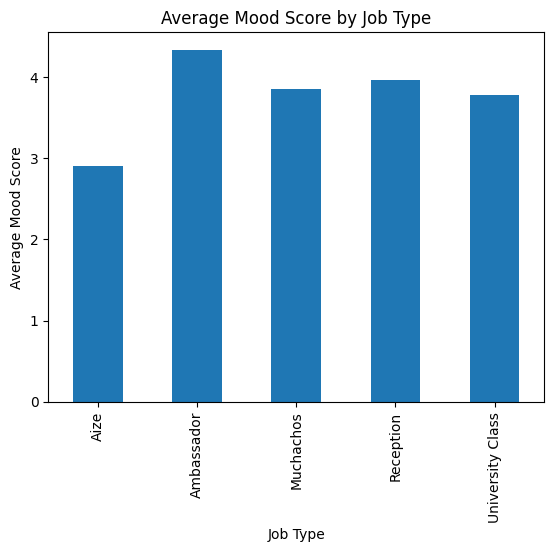

In [ ]:
#mood vs job type


moodsbyjob = pd.merge(work_sched, mood_data, on='Date')



average_mood_per_job = moodsbyjob.groupby('Job')['Mood Score'].mean()

average_mood_per_job.plot(kind='bar')
plt.title('Average Mood Score by Job Type')
plt.xlabel('Job Type')
plt.ylabel('Average Mood Score')
plt.show()

#type of job doesn't seem to affect my mood score much

In [ ]:
#merging daily listenign with moods to find top artist when happy and top artist when tired

top_7 = ['happy', 'creative', 'excited', 'curious', 'calm', 'tired', 'frazzled']



#  contains one of the top 7 words
contains_7 = mood_data[mood_data['Words'].str.contains('|'.join(top_7))]


top_artists_top_moods = daily_most_listened.merge(mood_data, on='Date', how='inner')


#print(top_artists_top_moods)


#filter where the mood is happy
happy_artists = top_artists_top_moods[top_artists_top_moods['Words'].str.contains('happy')]


happy_artists = happy_artists.groupby('Most_Listened_Artist')['Total_Minutes_Listened'].sum().reset_index()

#
happy_artists= happy_artists.sort_values(by='Total_Minutes_Listened', ascending=False)


#print(happy_artists)

#happy_artists.to_csv('happy_artists.csv', index=False)


tired_artists = top_artists_top_moods[top_artists_top_moods['Words'].str.contains('tired')]

#tired_artists.to_csv('tired_artists.csv', index=False)



creative_artists = top_artists_top_moods[top_artists_top_moods['Words'].str.contains('creative')]

creative_artists.to_csv('creative_artists.csv', index=False)


print(creative_artists)
happy_data = top_artists_top_moods[top_artists_top_moods['Mood Score'].isin([4, 5])]

total_listening_happy = happy_data['Total_Minutes_Listened'].sum()
print(len(happy_data))

sad_data = top_artists_top_moods[top_artists_top_moods['Mood Score'].isin([1, 2])]
print(len(sad_data))

total_listening_sad = sad_data['Total_Minutes_Listened'].sum()

avg_listening_per_entry_happy = total_listening_happy / len(happy_data)
avg_listening_per_entry_sad = total_listening_sad / len(sad_data)

print(total_listening_happy)
print(total_listening_sad)

print(avg_listening_per_entry_happy)#65 minutes of listening

print(avg_listening_per_entry_sad)#70 minutes of listening

neutral_data = top_artists_top_moods[top_artists_top_moods['Mood Score'].isin([3])]

total_listening_neutral = neutral_data['Total_Minutes_Listened'].sum()


avg_listening_neutral = total_listening_neutral / len(neutral_data)
print(len(neutral_data))

print(avg_listening_neutral)#53minutes




         Date Most_Listened_Artist  Total_Minutes_Listened  \
3  2022-10-20            Remi Wolf              102.269483   
7  2022-11-18            TTRRUUCES               57.707400   
11 2022-11-30           Snoop Dogg               26.850800   
17 2023-01-28              Beyoncé               30.498667   
31 2023-04-27     Alice Phoebe Lou               66.240183   
46 2023-05-24         Selena Gomez               99.786700   
48 2023-05-29             Dua Lipa               93.886717   
54 2023-06-24         Harry Styles               69.433967   
59 2023-07-09         Taylor Swift              166.402550   
62 2023-07-14         Taylor Swift               42.414050   
67 2023-07-26         Taylor Swift               75.371300   
69 2023-07-28         Taylor Swift               93.621717   
70 2023-07-30         Taylor Swift              184.533683   
79 2023-08-14             Coldplay               38.182183   
81 2023-08-18          Still Woozy               19.876133   
82 2023-

5    51
3    17
4    13
1    10
2     9
Name: Mood Score, dtype: int64


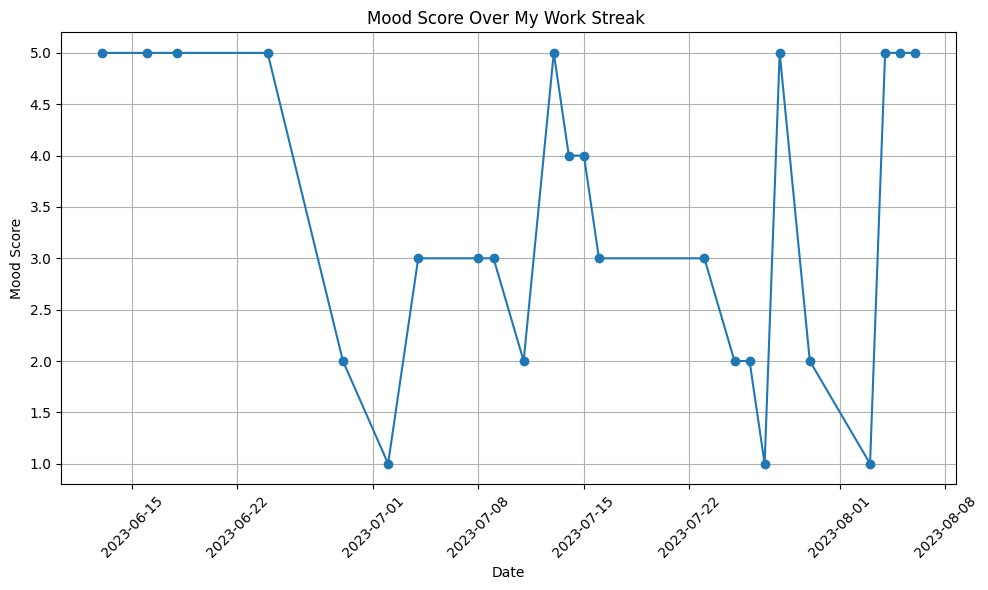

happy         6
creative      6
frazzled      5
sleepy        5
excited       4
             ..
busy          1
buzzing       1
limp          1
invincible    1
awesome       1
Name: Words, Length: 78, dtype: int64


In [ ]:
#work streak vs mood

#throughout the duration of my work streak i experienced many moods BUT i was above nuetral 50% of the time #hustle
start = '2023-06-13'
end = '2023-08-06'

mood_data['Date'] = pd.to_datetime(mood_data['Date'], format='%d/%m/%Y')
print(mood_counts)

work_streak_mood = mood_data[(mood_data['Date'] >= start) & (mood_data['Date'] <= end)]

plt.figure(figsize=(10, 6))
plt.plot(work_streak_mood['Date'], work_streak_mood['Mood Score'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Mood Score')
plt.title('Mood Score Over My Work Streak ')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


work_streak_mood_words = mood_data[(mood_data['Date'] >= start) & (mood_data['Date'] <= end)]


top_words = work_streak_mood_words['Words'].str.split(',').explode()



print(top_words.value_counts()) #top three words used during my work streak are creative happy and sleepy!
#out of 16 times I used creative 6 of them were during my work streaK :)


In [ ]:

mood_data['Day_of_week'] = mood_data['Date'].dt.day_name()

average_mood = mood_data.groupby('Day_of_week')['Mood Score'].mean()


average_steps = daily_steps_year.groupby('Day_of_week')['Total_Steps'].mean()


day_of_week_moods = pd.merge(average_mood, average_steps, left_index=True, right_index=True)
print(day_of_week_moods.sort_values(by='Mood Score'))


days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]


for i in range(1, len(days)):
    previous_day = days[i-1]
    current_day = days[i]

    previous_day_mood = day_of_week_moods.loc[previous_day, 'Mood Score']
    current_day_mood = day_of_week_moods.loc[current_day, 'Mood Score']

    mood_boost = ((current_day_mood - previous_day_mood) / previous_day_mood) * 100


    print(f"{previous_day} to {current_day}: {mood_boost:.2f}%")
# highest mood boost is 38.8% from sunday to monday!

             Mood Score  Total_Steps
Day_of_week                         
Sunday         2.923077  7796.461538
Thursday       3.733333  8684.679245
Tuesday        3.800000  7730.716981
Friday         4.058824  8413.096154
Monday         4.058824  7416.846154
Wednesday      4.111111  8642.566038
Saturday       4.285714  7986.480769
Sunday to Monday: 38.85%
Monday to Tuesday: -6.38%
Tuesday to Wednesday: 8.19%
Wednesday to Thursday: -9.19%
Thursday to Friday: 8.72%
Friday to Saturday: 5.59%
